In [1]:
from numpy import concatenate, zeros
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

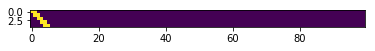

In [12]:
x_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.], zeros(98)]))[0:5, :]
plt.imshow(x_np)

In [4]:
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)#(input_size,hidden_size,num_layers)
input = torch.randn(5, 3, 10)#(seq_len, batch, input_size)
h0 = torch.randn(2, 3, 20) #(num_layers,batch,output_size)
c0 = torch.randn(2, 3, 20) #(num_layers,batch,output_size)
output, (hn, cn) = rnn(input, (h0, c0))


In [17]:
import torch
from torch import nn
import numpy as np
import matplotlib as mat
mat.use("TkAgg")
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
import cv2
torch.manual_seed(1)    # reproducible

hidden_siz = 50
hidden_lay = 1

LR = 0.02           # learning rate
class LSNN(nn.Module):
    def __init__(self):
        super(LSNN, self).__init__()
        self.lstm = nn.LSTM(  
            input_size=5,
            hidden_size=hidden_siz,    
            num_layers=hidden_lay,      
            batch_first=True,

        )
        self.hidden = (torch.autograd.Variable(torch.zeros(hidden_lay, 1, hidden_siz)),torch.autograd.Variable(torch.zeros(hidden_lay, 1, hidden_siz)))
        self.out = nn.Linear(hidden_siz, 1)

    def forward(self,x):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out,self.hidden= self.lstm(x,self.hidden)
        self.hidden=(Variable(self.hidden[0]),Variable(self.hidden[1]))
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1)

'''
    def forward(self, x, h_n,h_c):
        r_out,  = self.rnn(x, h_state)
        r_out = r_out.view(-1, 32)
        outs = self.out(r_out)
        return outs.view(-1, 10, 1), h_state
'''


lstmNN = LSNN()
optimizer = torch.optim.Adam(lstmNN.parameters(), lr=LR)  # optimize all rnn parameters
loss_func = nn.MSELoss()




loss_list = []
prediction_list = []
for step in range(94):
    steps = np.linspace(0, 100, 100, dtype=np.float32)
    
    if step == 0:
        x_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step: 5, :]
        y_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[5:6, :] 
    else:
        x_np = concatenate([
                            toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step: step+4, :],
                            prediction.view(1,100).data.numpy()])
        y_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step+5:step+6, :]
    
    #x_np = steps    # float32 for converting torch FloatTensor
    #y_np = steps
    x = Variable(torch.from_numpy(x_np).float())  # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np).float())
    x = x.permute(-1,0).view(1,100,5)
    y = y.view(1,100,1)
    prediction = lstmNN(x)
    prediction_list.append(prediction.data.view(100).numpy())

    loss = loss_func(prediction, y)     # cross entropy loss
    loss_list.append(loss)
    
    #train_loss += loss*X.size(0)
    
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward()                     # backpropagation, compute gradients
    optimizer.step()
    # apply gradients
    plt.figsize=(20, 10)
    plt.ion()
    plt.title(step,fontsize=24)
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    #plt.legend()
    plt.draw()
    plt.pause(0.01)
    plt.clf()

    plt.ioff()
    #plt.show()


<Figure size 432x288 with 0 Axes>

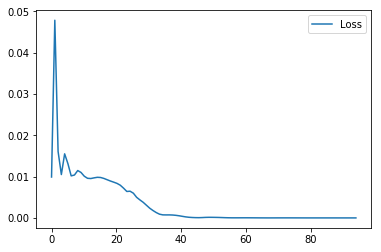

In [6]:
plt.plot(steps[:94], loss_list, label = 'Loss')
plt.legend()
plt.show()

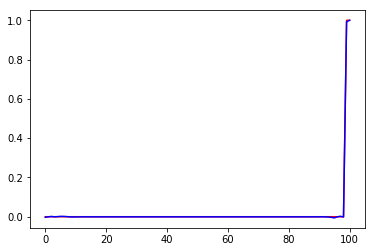

In [18]:
torch.manual_seed(1)    # reproducible

loss_func = nn.MSELoss()

loss_list = []
prediction_list = []
for step in range(94):
    steps = np.linspace(0, 100, 100, dtype=np.float32)
    
    if step <6:
        if step == 0:
            x_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step: 5, :]
            y_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[5:6, :] 
        else:
            
            x_np = concatenate([toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step: 5, :],
                                np.array(prediction_list[:step])])
            y_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step+5:step+6, :]
        
    else:
        x_np = np.array(prediction_list[-5:])
        y_np = toeplitz(concatenate([[1.], zeros(99)]),concatenate([[1.,1.,1.], zeros(97)]))[step+5:step+6, :]   
    
    #x_np = steps    # float32 for converting torch FloatTensor
    #y_np = steps
    x = Variable(torch.from_numpy(x_np).float())  # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np).float())

    x = x.permute(-1,0).view(1,100,5)
    y = y.view(1,100,1)
    with torch.no_grad():
        prediction = lstmNN(x)
        #print("pre ",prediction.data.size())
        prediction_list.append(prediction.data.view(100).numpy())
        #print(prediction_list)
        loss = loss_func(prediction, y)     # cross entropy loss
        loss_list.append(loss)
    
    #train_loss += loss*X.size(0)
    
    # apply gradients
    plt.figsize=(20, 10)
    plt.ion()
    plt.title(step,fontsize=24)
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    #plt.legend()
    plt.draw()
    plt.pause(0.5)
    plt.clf()

    plt.ioff()
    #plt.show()
plt.plot(steps, y_np.flatten(), 'r-')
plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
plt.show()

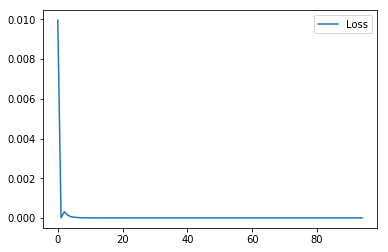

In [19]:
plt.plot(steps[:94], loss_list, label = 'Loss')
plt.legend()
plt.show()